In [365]:
from itertools import repeat

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
import seaborn as sns

from gradient_coding import GradientCoding
from multiplexed_sgc import MultiplexedSGC
from selective_repeat_sgc import SelectiveRepeatSGC
from no_coding import NoCoding
from utils import get_durations, load_profile, slugify, folder_params, DELAY_DIR, ridge_plot

sns.set_theme()

models = {
    'GC': GradientCoding,
    'SRSGC': SelectiveRepeatSGC,
    'MSGC': MultiplexedSGC,
    'No Coding': NoCoding,
}

colors = {
    'GC': 'tab:blue',
    'SRSGC': 'tab:green',
    'MSGC': 'tab:orange',
    'No Coding': 'tab:red'
}

sns.set_theme()

# 1. Probing Profile

In [366]:
# folder = 'sam-gc-cnn_profile_est_desktop'
# folder = 'sam-gc-cnn_profile_est_desktop_long'
# folder = 'sam-gc-cnn_profile_est_desktop_long2'
# folder = 'sam-gc-cnn_profile_est_desktop_long4'
# folder = 'sam-gc-cnn_profile_est_desktop_long4_real'
folder = 'sam-gc-cnn_profile_est_desktop_long4'

workers, invokes, profile_loads, batch, comp_type, regions = folder_params(folder)

# region = 'London'
region = 'Canada'


print(f'{workers=}', f'{invokes=}', f'{profile_loads=}', f'{batch=}', f'{comp_type=}', f'{regions=}', end="\n")

workers=256 invokes=100 profile_loads=[0.0, 0.25, 0.5, 0.75, 1.0] batch=4096 comp_type='no_forloop' regions=['Canada', 'London']


In [166]:
# load all profiles

dur_list = []
for load in profile_loads:
    rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder)
    durs = get_durations(rounds).T
    
    #NOTE:
    durs = np.random.permutation(durs)
    
    dur_list.append(durs)
    
dur_list = np.array(dur_list)

dur_list[1, :, 0] = dur_list[1, :, 20] + np.random.rand(workers)*0.1 

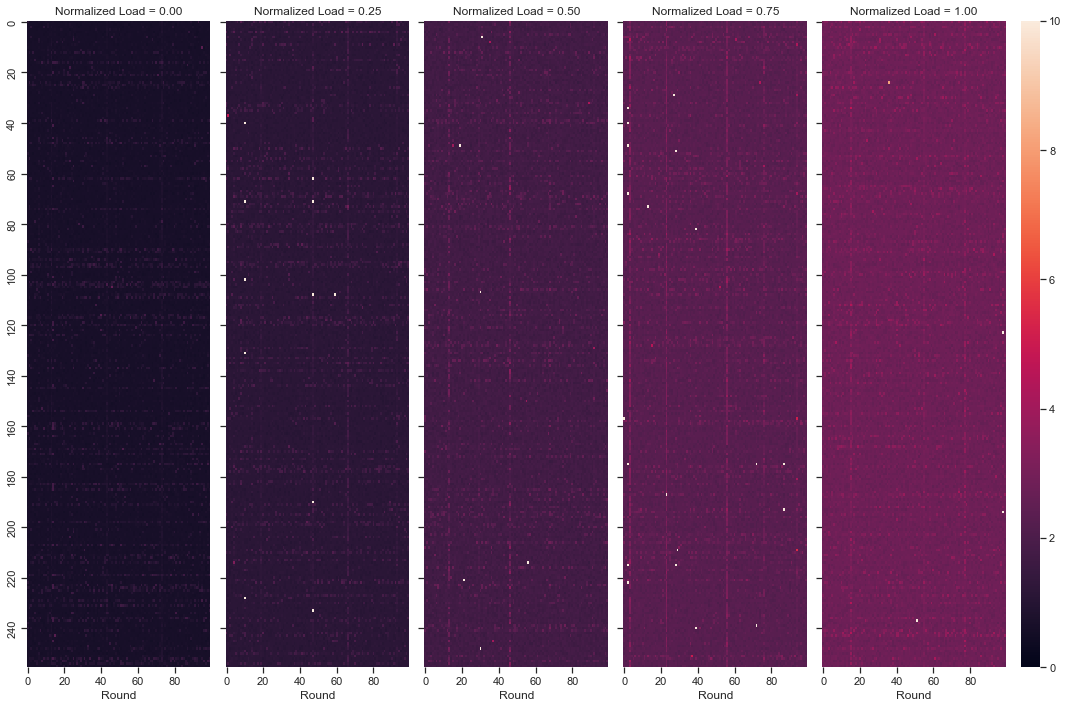

In [167]:
from matplotlib.ticker import AutoLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# analyze straggler pattern of each profile
fig, axs = plt.subplots(1, len(profile_loads) + 1, figsize=(15, 10), 
                        gridspec_kw={"width_ratios":[1, 1, 1, 1, 1, 0.1]},
                        tight_layout=True)

for i, (durs, load, ax) in enumerate(zip(dur_list, profile_loads, axs.flat)):
    
    
    sns.heatmap(durs, ax=ax, vmin=0, vmax=10, yticklabels=20, xticklabels=20, cbar_ax=axs[-1])
    ax.set_title(f'Normalized Load = {load:.2f}')
    ax.set_xlabel('Worker')
    ax.set_xlabel('Round')
    ax.tick_params(left=True, bottom=True)
    if i != 0:
        ax.set_yticklabels([])

In [168]:
# FIND BASE_COMP
    
lr = LinearRegression().fit(
    y = np.array(dur_list).reshape(-1,),
    X = np.repeat(profile_loads, dur_list[0].size).reshape(-1, 1)
) 
base_comp = lr.coef_[0]

print(f'{base_comp = :.4f}')

base_comp = 2.2013


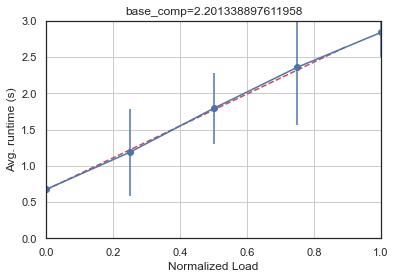

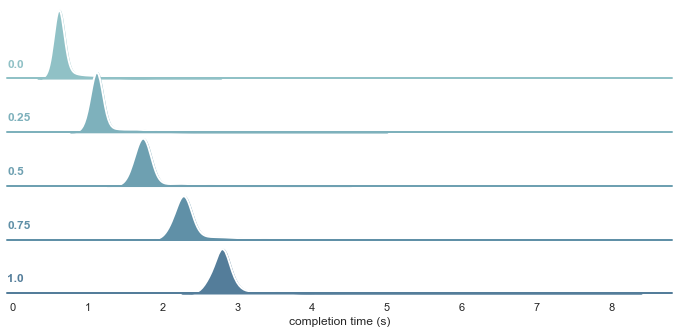

In [189]:
# Plot linear regression

fig, ax = plt.subplots()
ax.errorbar(x=profile_loads,
            y=[d.mean() for d in dur_list],
            yerr=[d.std() for d in dur_list],
            label=region, marker='o'
)

x = np.arange(0, 1, 0.1)
y = x * lr.coef_[0] + lr.intercept_
ax.plot(x, y, 'r--')

ax.set(xlabel = 'Normalized Load',
       ylabel = 'Avg. runtime (s)',
       xlim=(0, 1), ylim=(0, 3))
ax.set_title(f'{base_comp=}')
ax.grid()


# Ridge plot

l = np.array([[l] * dur_list[0].size for l in profile_loads]).flatten()
x = np.array(dur_list).flatten()
sel = x < 10
x = x[sel]
l = l[sel]

ridge_plot(x, l, bw_adjust=3, xlabel='completion time (s)');


# fig, ax = plt.subplots()
# sns.violinplot(x=l, y=x, ax=ax)

# 2. Selecting Scheme Parameters 

In [368]:
#  LOAD BASE (REFERENCE) PROFILE

n_jobs = 80  # number of jobs to complete
base_load = 0.0
mu = 1.0

max_delay = invokes - n_jobs  # total number of rounds profiled - number of jobs to complete

rounds = load_profile(workers, invokes, base_load, batch, comp_type, region, folder)
base_delays = get_durations(rounds).T # (workers, rounds)

In [207]:
# RUN ALL PARAMS + GENERATE PLOTS
n = workers

def find_runtime(Model, params):
    load = Model.normalized_load(n, *params)
    delays = base_delays + (load - base_load) * base_comp
    model = Model(workers, *params, n_jobs, mu, delays)
    model.run()
    durations = model.durations
    assert (durations >= 0).all()
    return durations.sum()


runtimes_df = []
for model_name, Model in models.items():
    params_combinations = list(Model.param_combinations(workers, n_jobs, max_delay))
    loads = [Model.normalized_load(n, *params) for params in params_combinations]
    runtimes = [find_runtime(Model, params) for params in tqdm(params_combinations)]
    
    runtimes_df += zip(repeat(model_name), runtimes, loads, params_combinations)
    
runtimes_df = pd.DataFrame(runtimes_df, columns=['model_name', 'runtime', 'load', 'params'])
df = runtimes_df.loc[runtimes_df.groupby('model_name')['runtime'].idxmin()]
df = df.set_index('model_name')

df

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/70144 [00:00<?, ?it/s]

  0%|          | 0/25600 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [322]:
# save estimated runtimes
fname = f'mu{slugify(mu)}-base_load{slugify(base_load)}-njobs{n_jobs}-base_comp{slugify(base_comp)}-{region}'

fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
df.to_csv(fpath)    

fname += '_all'
fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
runtimes_df.to_csv(fpath)

In [369]:
# load estimated runtimes
import ast

fname = f'mu{slugify(mu)}-base_load{slugify(base_load)}-njobs{n_jobs}-base_comp{slugify(base_comp)}-{region}'

fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
df = pd.read_csv(fpath, index_col='model_name', converters={"params": ast.literal_eval})  

fname += '_all'
fpath = (DELAY_DIR / folder / fname).with_suffix('.csv')
runtimes_df = pd.read_csv(fpath, index_col=0, converters={"params": ast.literal_eval})

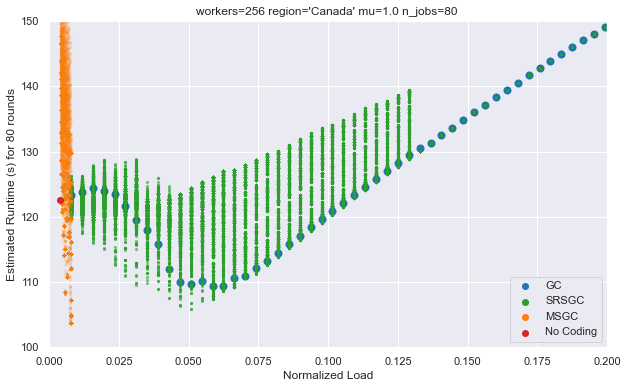

In [301]:
fig,ax = plt.subplots(figsize=(10, 6))

alpha = {
    'GC': 1,
    'SRSGC': 0.6,
    'MSGC': 0.1,
    'No Coding': 1,
}
size = {
    'GC': 65,
    'SRSGC': 10,
    'MSGC': 10,
    'No Coding': 50,
}

for model_name in models:
    model_time = runtimes_df[runtimes_df['model_name']==model_name]
    sns.scatterplot(data=model_time,
                    x="load", y="runtime",
                    linewidth=0, alpha=alpha[model_name], 
                    c=colors[model_name], s=size[model_name], label=model_name)

ax.set_xlabel('Normalized Load')
ax.set_ylabel(f'Estimated Runtime (s) for {n_jobs} rounds')
ax.set_title(f'{workers=} {region=} {mu=} {n_jobs=} ')

ax.grid(True)

ax.set_ylim(100, 150)
ax.set_xlim(0, 0.2)

leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([50])


In [370]:
# best params
df = df.sort_values(by=['runtime'])
display(df)

,runtime,load,params
model_name,,,
MSGC,103.727155,0.007543,"(1, 2, 27)"
SRSGC,105.924997,0.050781,"(2, 3, 23)"
GC,109.358945,0.062500,"(15,)"
No Coding,122.638171,0.003906,()


(0.0, 83.95)

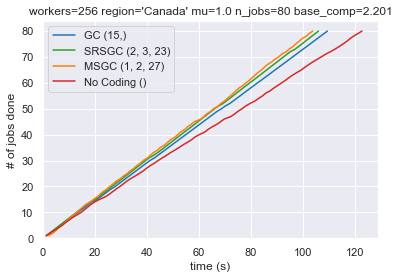

In [307]:
fig, ax = plt.subplots()
for model_name, Model in models.items():
    best_params = df.loc[model_name, 'params']
    load = df.loc[model_name, 'load']
    
    delays = base_delays + (load - base_load) * base_comp
    model = Model(workers, *best_params, n_jobs, mu, delays)
    model.run()
    durations = model.durations
    
    x = durations[durations>0].cumsum()
    x = x[-n_jobs:] 
    ax.plot(x, np.arange(n_jobs)+1, label=f'{model_name} {best_params}', c=colors[model_name])


ax.set_xlabel('time (s)')
# ax.set_ylabel('train acc')
ax.set_ylabel('# of jobs done')
ax.grid(True)
ax.set_title(f'{workers=} {region=} {mu=} {n_jobs=} {base_comp=:.3f}')
ax.legend();
ax.set_xlim(0)
ax.set_ylim(0)

# 3. Real Runtimes

In [395]:
folder_real = folder + '_real_2'
invokes = 500
mu = 1


In [396]:
# load all real profiles

dur_list = []
for model_name, load in zip(df.index, df['load']):
    rounds = load_profile(workers, invokes, load, batch, comp_type, region, folder_real)
    
    durs = get_durations(rounds).T
    #NOTE:
    durs = np.random.permutation(durs)
    
    dur_list.append(durs)
dur_list = np.array(dur_list)



n_jobs = dur_list[0].shape[1] - max_delay  # number of jobs to complete


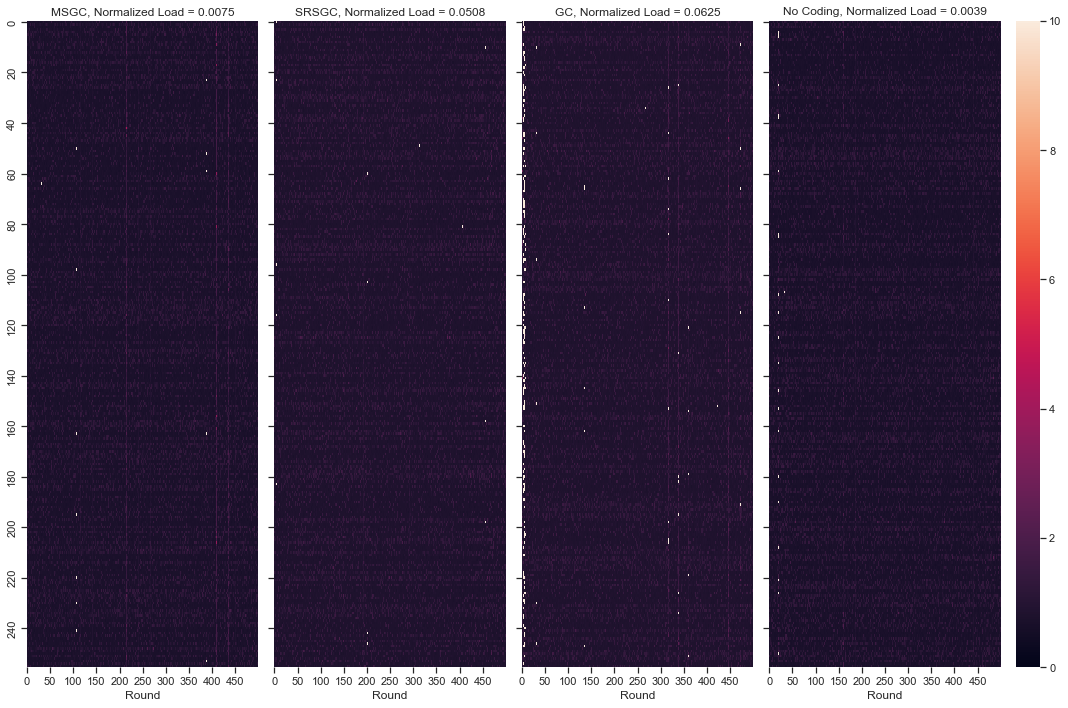

In [373]:
fig, axs = plt.subplots(1, len(dur_list) + 1, figsize=(15, 10), 
                        gridspec_kw={"width_ratios":[1, 1, 1, 1, 0.1]},
                        tight_layout=True)

for i, (durs, load, ax, model_name) in enumerate(zip(dur_list, df['load'], axs.flat, df.index)):
    
    sns.heatmap(durs, ax=ax, vmin=0, vmax=10, yticklabels=20, xticklabels=50, cbar_ax=axs[-1])
    ax.set_title(f'{model_name}, Normalized Load = {load:.4f}')
    ax.set_xlabel('Worker')
    ax.set_xlabel('Round')
    ax.tick_params(left=True, bottom=True)
    if i != 0:
        ax.set_yticklabels([])

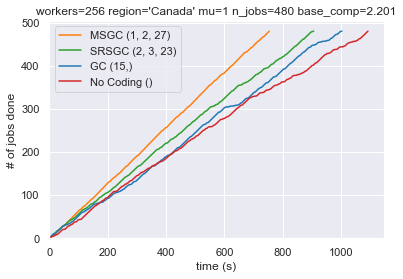

In [397]:
#%% MULTIPLE RUNS

np.random.seed(10)    

num_tries = 10
num_splits = 20

runtimes = {}

fig, ax = plt.subplots()
for model_name, durs in zip(df.index, dur_list):
    
    runtimes[model_name] = []
    
    x = []
    for n in range(num_tries):
            
        durs_split = np.array_split(durs, num_splits, axis=1)
        durs_split = [durs_split[i] for i in np.random.permutation(num_splits)]
        durs_shuffled = np.concatenate(durs_split, axis=1)

        Model = models[model_name]
        best_params = df.loc[model_name, 'params']
        load = df.loc[model_name, 'load']

        model = Model(workers, *best_params, n_jobs, mu, durs_shuffled)
        model.run()
        
        time = model.durations.sum()
        runtimes[model_name].append(time)
        
        durations = model.durations
        _x = durations[durations>0].cumsum()
        _x = _x[-n_jobs:]
        x.append(_x)
    
    x = np.array(x).mean(0)
    ax.plot(x, np.arange(n_jobs)+1, label=f'{model_name} {best_params}', c=colors[model_name])

ax.grid(True)
ax.legend()

ax.set(
    title=f'{workers=} {region=} {mu=} {n_jobs=} {base_comp=:.3f}',
    xlabel='time (s)', ylabel= '# of jobs done',
    xlim=(0, None), ylim=(0, None)
);

In [398]:
df = df[['load', 'params']]
for model_name in df.index:
    runtime_mean = np.mean(runtimes[model_name])
    runtime_std = np.std(runtimes[model_name])

    df.loc[model_name, 'runtime'] = f'{runtime_mean:.2f} ± {runtime_std:.2f} (s)'
    
display(df)

,load,params,runtime
model_name,,,
MSGC,0.007543,"(1, 2, 27)",752.84 ± 11.66 (s)
SRSGC,0.050781,"(2, 3, 23)",905.04 ± 16.49 (s)
GC,0.062500,"(15,)",1001.42 ± 24.04 (s)
No Coding,0.003906,(),1090.66 ± 12.72 (s)


[Text(0, 0.5, 'Total Runtime (s)')]

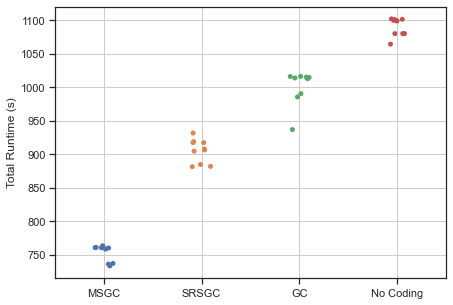

In [415]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.stripplot(pd.DataFrame(runtimes), ax=ax)
ax.grid(True)
ax.set(
    ylabel='Total Runtime (s)'
)
